**Part 1 - Data Exploration**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import seaborn as sns


In [7]:
df = pd.read_json(r'logins.json')


In [8]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [10]:
df.describe()

C:\Users\admin\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [11]:
df.set_index('login_time', inplace=True)
df['count'] = 1
df.sort_index(inplace=True)
df_agg = df.resample("15min").sum()

In [12]:
df_agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


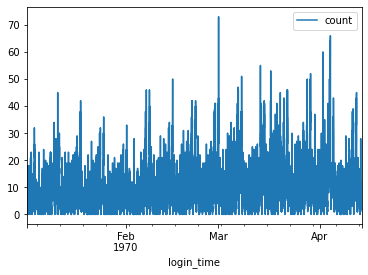

In [13]:
df_agg.plot()
plt.show()

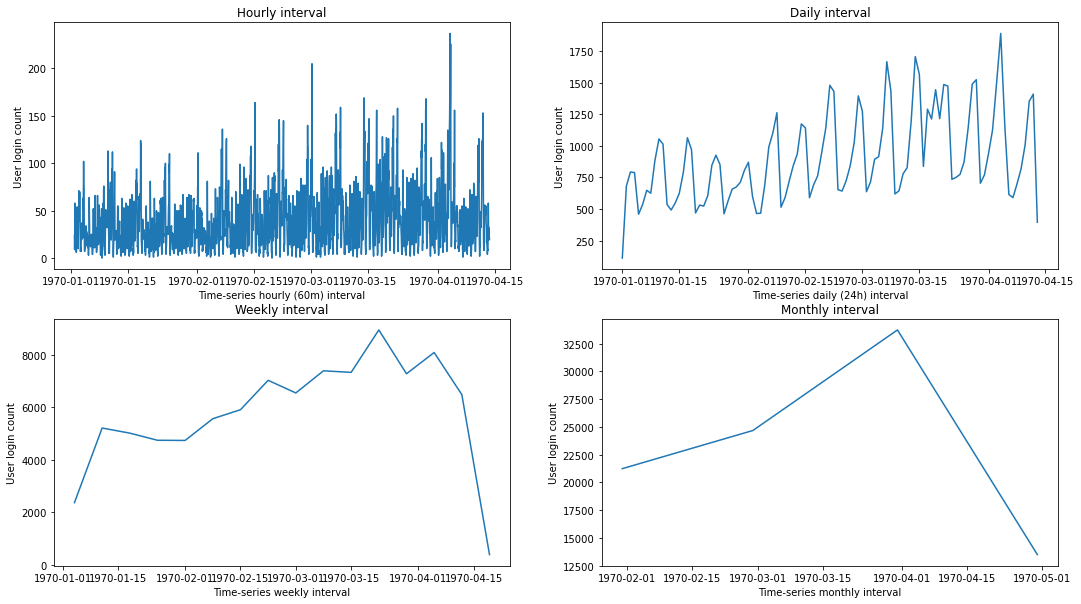

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(df.resample('60T').sum());
ax1.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# Daily interval
ax2.plot(df.resample('D').sum());
ax2.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax3.plot(df.resample('W').sum());
ax3.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax4.plot(df.resample('M').sum());
ax4.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

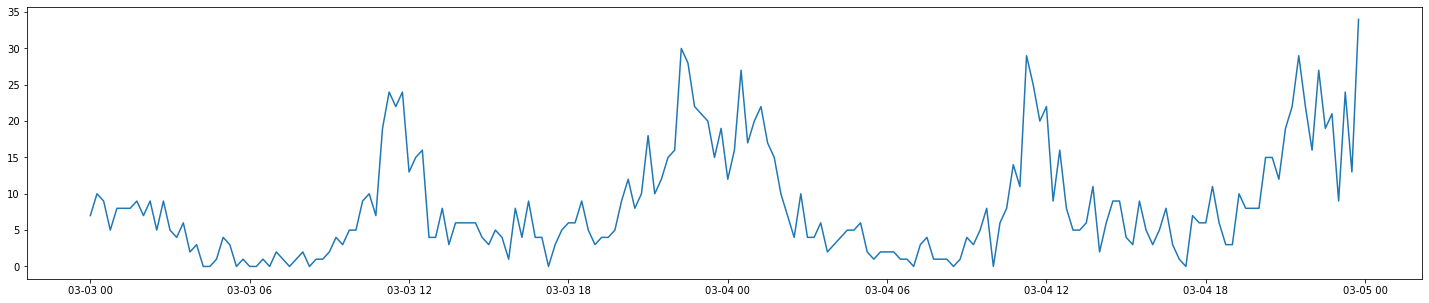

In [15]:
plt.figure(figsize=(25,5));
#df_agg.loc['1970-03-03':'1970-03-04' ].plot()
plt.plot(df_agg.loc['1970-03-03':'1970-03-04' ])

As can be seen from the plot above that the demand or logins by users take a peak around the noon and the midnight of every day.

**Part 2 - Experiment and Metrics Design**

Answer-1: As per the given information, on weekdays, this implies that drivers tend to be in Gotham city during night and tend to be in Metropolis city during day. But drivers tend to be in both the cities during weekdays is very less unless they work for more than 12 hours. In weekends since the activity in both the cities is reasonable drivers tend to move to both the cities. The key metric I would use is change in weekday activity. Here we have to check during the daytime hours on weekdays, is there an increase of cars entering the bridge from Gotham AND during the night is there an increase of cars entering the bridge from Metropolis. We can keep track the record of cars crossing the toll bridge and observe the change in ticket sales.


Answer-2 we conduct a z-test, assuming sample size > 30 drivers. Compare number driver bridge crossings.

$h_0$: No difference in driver bridge crossings, after toll reimbursement experiment. $h_a$: Increase in driver bridge crossings, after toll reimbursement experiment. 

Calculate z-score of average frequency of drivers serving both cities, post-reimbursement experiment. Set $a$=0.05. Determine if z-score's p-value falls below this significance threshold.

If p-value < 0.05, then the post-reimbursement crossings are so high that it's unlikely to occur under the null hypothesis of pre-reimbursement crossings. This result would support a significant increase in driver bridge crossings after the toll reimbursement is introduced, indicating that this policy was a success.

However, the caveat is that $a$ significance levels are set arbitrarly and p-values fluctuate depending on sample size. So depending on how wide of a margin the post-reimbursement increase is, our experiment could either support or reject the policy.

As a result, I recommend only considering the policy a success if the margin is wide enough (and p-value far below 0.05) that it is obvious that a significant post-reimbursement increase has occurred even in the midst of the aforementioned fluctuations.

**Part 3 - Feature engineering and predictive modelling**

In [17]:
dff = pd.read_json(r'ultimate_data_challenge.json')


In [18]:
dff.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [19]:
dff.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [20]:
#fill missing values by mean values of the column avg_rating_of_driver and avg_rating_by_driver
dff.avg_rating_by_driver.fillna(dff.avg_rating_by_driver.mean(),inplace=True)
dff.avg_rating_of_driver.fillna(dff.avg_rating_of_driver.mean(),inplace=True)

In [21]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
#converting 'last_trip_date' column from object type to timestamp
dff['last_trip_date'] = pd.to_datetime(dff['last_trip_date'])

In [23]:
#set current date 
current_date = dff['last_trip_date'].max()

#find if user qualifies as active
dff['active'] = dff['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
dff.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [24]:
dff['active'].value_counts()


0    31196
1    18804
Name: active, dtype: int64

In [25]:
#drop rows with no phone information, since we cannot infer that without building a predictive model
dff = dff.drop(dff[dff.phone.isna()==True].index,axis=0)
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  object        
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  active                  49604 non-null  int64 

In [26]:
#create dummy variables for categorical features
df_features = pd.get_dummies(dff,columns=['city','phone','ultimate_black_user'])
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [27]:
#set target and drop unuseful columns
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [29]:
#scale data
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)

In [30]:
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

In [31]:
#build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [32]:
rf.score(X_test,y_test)


0.7511339582703357

In [33]:
cv_score=cross_val_score(rf,X_test,np.ravel(y_test),cv=5)
print('Mean Cross Validated Score:',np.mean(cv_score))

Mean Cross Validated Score: 0.7481098155521249


In [34]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.299879
4,weekday_pct,0.132965
6,avg_rating_by_driver,0.114244
1,avg_rating_of_driver,0.081876
0,trips_in_first_30_days,0.079904
3,surge_pct,0.078952
2,avg_surge,0.065933
8,city_King's Landing,0.047197
11,phone_iPhone,0.019841
10,phone_Android,0.019736


In [35]:
#generate confusion matrix
confusion_matrix(y_test,y_pred)

array([[4965, 1235],
       [1234, 2487]], dtype=int64)

In [36]:
#initialize model
logit = LogisticRegression(solver='lbfgs')
#set parameter grid
param_grid = {'C':np.arange(0.5,5.1,0.1)}
#instantiate and fit grid search object
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])})

In [37]:
grid.best_estimator_.C


4.699999999999999

In [39]:
#find coefficients from Logistic Regression
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(df_features.columns),logit_coef.coef_[0]),index=range(df_features.columns.shape[0]),columns=['feature','coefficient'])
df_coef

,feature,coefficient
0,trips_in_first_30_days,0.113285
1,avg_rating_of_driver,-0.329935
2,avg_surge,2.529198
3,surge_pct,-1.449693
4,weekday_pct,-0.242823
5,avg_dist,0.157502
6,avg_rating_by_driver,-1.344972
7,city_Astapor,-0.770265
8,city_King's Landing,1.115123
9,city_Winterfell,-0.249166


In [40]:
print(np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv=5)))


0.7420622917851629


We have not gained any advantage using Logistic Regression for our classifier, the models perform almost identically.

In conclusion, we have extracted very valuable information from this dataset.

First, we have built a predictive model with 75% accuracy, that will be useful for future prediction.

Secondly, the insights from the model are arguably more important and lucrative for the company. Random Forest has given us the most important features and Logistic Regression shows us the effect of the features through the coefficients. Taking the three most important features, we can see the following effects on the "activity" of a rider after 6 months.

Average distance: This one is tricky because while our logistic regression model shows that an increase in average distance per trip in the first 30 days increases our chances of being an active user, interestingly, the mean avg_dist is larger for inactive riders than for active. Due to this ambiguity in the data, it may not be advisable to try to increase the distance of trips taken in the first 30 days.

weekday percentage: The chance of being an active user decrease as the percentage of week day use goes up. From this we can see that encouraging people to use the app on the weekend will be beneficial for the company revenue.

average rating by driver: For this feature, there is a decreased likelihood of being an active user as your rating goes up.

trips in the first 30 days: As the number of trips in the first 30 days increases, so does the chance that a rider is active after 6 months.

Based on these insights gained from the model, there are several recomendations for the company.

Offer incentives to riders to use the app on the weekends Incentivize riders to take more trips during their first 30 days on the app Encourage drivers not to artificially inflate the ratings they give to users, especially if the driver can tell that they've never done this before. Following these guidelines will increase the chances of more active users in the long term, and therefore more revenue for the company.